In [1]:
import torch 
import detectron2

import numpy as np
import random
import glob
import os
import contextlib
import io
import time
import json

import matplotlib.pyplot as plt

from fvcore.common.file_io import PathManager

from pycocotools.coco import COCO

from detectron2.config import get_cfg
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import detection_utils as utils
from detectron2.data import build_detection_train_loader
from detectron2.data import build_detection_test_loader
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor
from detectron2.modeling import build_model
from detectron2.structures import BoxMode

# local .json file with local path info
geladas_root = os.path.dirname(os.path.dirname(os.getcwd()))
local_paths_file = os.path.join(geladas_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(
    os.path.join(local_paths["general_dection_path"],
                 "detectron2_classes")
)
from DetectionDatasetMapper import DetectionDatasetMapper
from PrecisionRecallEvaluator import PrecisionRecallEvaluator
from GroundtruthVisualizer import GroundtruthVisualizer

In [2]:
detectron2.__version__

'0.2.1'

In [3]:
base_folder = local_paths["annotations_folder"]
images_folder = os.path.join(base_folder, "annotated_images")

In [4]:
models_folder = os.path.basename(os.getcwd(), "output")
model_name = "LRscheduler-cropped-color-aug_maxiter-6400_lr-0.0019_detectPerIm-200_minsize-0_batchsize-8"
yaml_file = os.path.join(models_folder, model_name, 'config.yaml')
print(yaml_file)

/home/golden/overhead-video-method/geladas/detection/model_training/output/LRscheduler-cropped-color-aug_maxiter-6400_lr-0.0019_detectPerIm-200_minsize-0_batchsize-8/config.yaml


In [5]:
cfg = get_cfg()
with open(yaml_file, 'r') as f:
    yaml_string = f.read()
cfg = cfg.load_cfg(yaml_string)

cfg.SOLVER.IMS_PER_BATCH = 1
cfg.INPUT.CROP.ENABLED = False

weights_path = sorted(
    glob.glob(os.path.join(cfg.OUTPUT_DIR, "best-model-config-iter-*.pth"))
)[-1]
print(weights_path)
cfg.MODEL.WEIGHTS = os.path.join(weights_path)

./output/LRscheduler-cropped-color-aug_maxiter-6400_lr-0.0019_detectPerIm-200_minsize-0_batchsize-8/best-model-config-iter-1319-loss-0.5798989905295178.pth


In [6]:
print(cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 ????
print(cfg.MODEL.ROI_HEADS.NUM_CLASSES)

0.05
2


In [7]:
train_json = os.path.join(base_folder, 'train.json') 
val_json = os.path.join(base_folder, 'val.json')
test_json = os.path.join(base_folder, 'test.json')
# square_train_json = os.path.join(base_folder, 'coco_export-2022-01-05T15_53_24.697Z-training.json')
square_train_json = os.path.join(base_folder, 'coco_export-2022-01-06T14_28_01.837Z-original_annotations.json')


register_coco_instances("train", {}, train_json, images_folder)
register_coco_instances("val", {}, val_json, images_folder)
register_coco_instances("test", {}, test_json, images_folder)
register_coco_instances("train_square", {}, square_train_json, images_folder)

train_dicts = DatasetCatalog.get("train")
val_dicts = DatasetCatalog.get("val")
test_dicts = DatasetCatalog.get("test")
square_train_dicts = DatasetCatalog.get("train_square")

num_train_images = len(train_dicts)
num_val_images = len(val_dicts)
num_test_images = len(test_dicts)
num_square_train_images = len(square_train_dicts)
print(f"{num_train_images} training images \n",
      f"{num_val_images} validation images \n",
      f"{num_test_images} test images \n",
      f"{num_square_train_images} square train images")

69 training images 
 13 validation images 
 16 test images 
 33 square train images


In [8]:
train_metadata = MetadataCatalog.get("train")
train_metadata.get("thing_classes")

['gelada', 'human']

In [9]:
dataset_name = "train_square"
mapper = DetectionDatasetMapper(cfg, is_train=False, calc_val_loss=False)
# loader = build_detection_train_loader(cfg, mapper=mapper, )
loader = build_detection_test_loader(cfg, dataset_name, mapper)

In [10]:
for batch in loader:
    break

In [15]:
batch[0]['image'].shape

torch.Size([3, 2160, 3840])

In [1]:
cfg.DATASETS.TEST = (dataset_name, )
predictor = DefaultPredictor(cfg)

if dataset_name == 'train':
    dataset_dict = train_dicts
elif dataset_name == 'val':
    dataset_dict = val_dicts
elif dataset_name == 'test':
    dataset_dict = test_dicts
elif dataset_name == 'train_square':
    dataset_dict = square_train_dicts

for d in random.sample(dataset_dict, 20):
    im = utils.read_image(
        d["file_name"], format=cfg.INPUT.FORMAT
    )
    outputs = predictor(im)
    v = GroundtruthVisualizer(im[:, :, ::],
                   metadata=train_metadata,
                   scale=0.8,
                   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(20,20))
    plt.imshow(v.get_image()[:, :, ::-1])

In [16]:
dataset_metadata = MetadataCatalog.get(dataset_name)
json_file = PathManager.get_local_path(dataset_metadata.json_file)
with contextlib.redirect_stdout(io.StringIO()):
    coco_api = COCO(json_file)

In [17]:
coco_api.createIndex()

creating index...
index created!


In [18]:

# Check training

evaluator = PrecisionRecallEvaluator(dataset_name, cfg, distributed=False)
# evaluator = COCOEvaluator(dataset_name, cfg, distributed=False)
evaluator.reset()

show_ims = False
show_gts = False

cfg.DATASETS.TEST = (dataset_name, )
# predictor = DefaultPredictor(cfg)

model = build_model(cfg)
_ = model.eval()

checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)

all_outputs = []

t = time.time()
with torch.no_grad():
    for batch_num, batch in enumerate(loader):
        
        if batch_num % 50 == 0:
            print(f'processed batch {batch_num}')

        outputs = model(batch)
        

        all_outputs.extend(outputs)
    
        evaluator.process(batch, outputs)
        if show_ims:   
            for ind, output in enumerate(outputs):
                im = (
                    np.transpose(batch[0]['image'].numpy(), (1, 2, 0))
                ).astype(int)
                
                im_id = batch[ind]['image_id']

                gts=coco_api.loadAnns(coco_api.getAnnIds(imgIds=[im_id]))
                anno_dict = {}
                for gt in gts:
                    gt['bbox_mode'] = BoxMode.XYWH_ABS
                anno_dict['annotations'] = gts
                
                scale = 0.8
                if show_gts:
                    v = GroundTruthVisualizer(im,
                               metadata=train_metadata,
                               scale=1.0,
                    )
                    v_gt = v.draw_dataset_dict(anno_dict)
                    im = v_gt.get_image()
                    plt.figure(figsize=(20, 20))
                    plt.imshow(v_gt.get_image()[:, :, ::-1])
                v = Visualizer(im,
                               metadata=train_metadata,
                               scale=scale,
                )
                v_im = v.draw_instance_predictions(output["instances"].to("cpu"))
                
                plt.figure(figsize=(20, 20))
                plt.imshow(v_im.get_image()[:, :, ::-1])
                
                
        if batch_num >= 1000:
            print(f'batch {batch_num}')
            break
total_time = time.time() - t
print(f"fps: {batch_num/total_time}, total_time {total_time}, num_frames {batch_num}")

coco_result = evaluator.evaluate()

processed batch 0
fps: 2.2843538717730403, total_time 14.008337497711182, num_frames 32
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.03 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.00 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.648
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.637
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10

In [19]:
precisions = coco_result['bbox']['precision']
precision = precisions[:, :, 0, 0, -1]
precision = precision[precision > -1]
ap = np.mean(precision) if precision.size else float("nan")
print(ap)

0.3432999797284439


0.3432999797284439


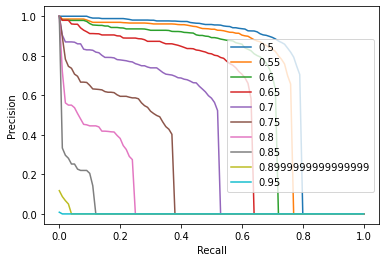

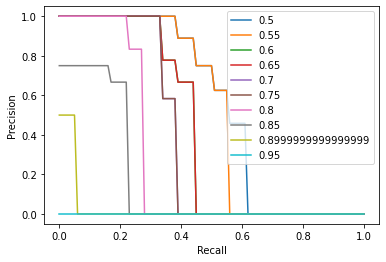

In [20]:
params = coco_result['bbox']['params']
precision = coco_result['bbox']['precision']
print(np.mean(precision[:, :, 0, 0, 2]))
for obj_class, _ in enumerate(precision[0, 0, :, 0, 0]):
    plt.figure()
    for iou_ind, iou_thrsh in enumerate(params.iouThrs):
        plt.plot(params.recThrs, precision[iou_ind, :, obj_class, 0, 2], label=iou_thrsh)
    plt.legend()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    

In [25]:
coco_result['bbox'].keys()

dict_keys(['precision', 'params', 'res', 'coco_eval'])

In [31]:
coco_result['bbox']['params']